Device: cpu
Epoch 0: loss 1.370
Epoch 5: loss 0.992
Epoch 10: loss 0.880
Epoch 15: loss 0.785
Epoch 20: loss 0.696
Epoch 25: loss 0.616
Epoch 30: loss 0.544
Epoch 35: loss 0.481
Epoch 40: loss 0.427
Epoch 45: loss 0.378
Epoch 50: loss 0.336
Epoch 55: loss 0.300
Epoch 60: loss 0.268
Epoch 65: loss 0.241
Epoch 70: loss 0.216
Epoch 75: loss 0.195
Epoch 80: loss 0.177
Epoch 85: loss 0.161
Epoch 90: loss 0.147
Epoch 95: loss 0.134
Epoch 100: loss 0.123
Epoch 105: loss 0.114
Epoch 110: loss 0.105
Epoch 115: loss 0.098
Epoch 120: loss 0.091
Epoch 125: loss 0.085
Epoch 130: loss 0.080
Epoch 135: loss 0.076
Epoch 140: loss 0.071
Epoch 145: loss 0.068
Epoch 150: loss 0.065
Epoch 155: loss 0.062
Epoch 160: loss 0.059
Epoch 165: loss 0.057
Epoch 170: loss 0.055
Epoch 175: loss 0.053
Epoch 180: loss 0.051
Epoch 185: loss 0.050
Epoch 190: loss 0.048
Epoch 195: loss 0.048
Epoch 200: loss 0.046
Epoch 205: loss 0.046
Epoch 210: loss 0.045
Epoch 215: loss 0.044
Epoch 220: loss 0.043
Epoch 225: loss 0.04

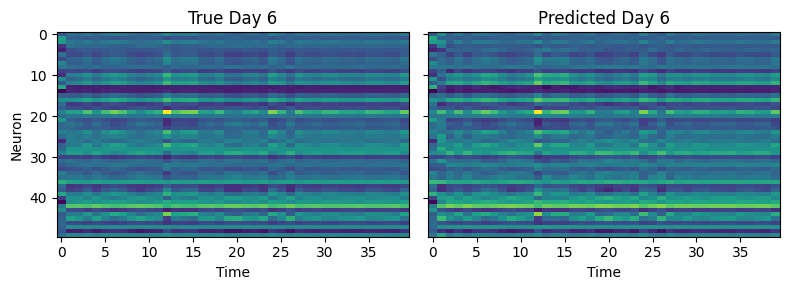

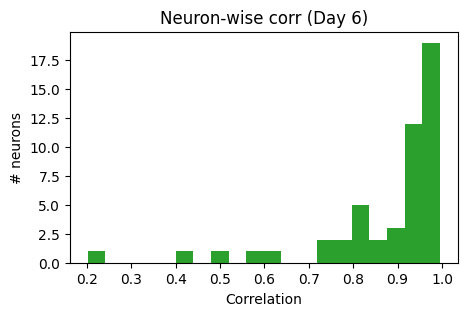

Mean corr Day 6: 0.873


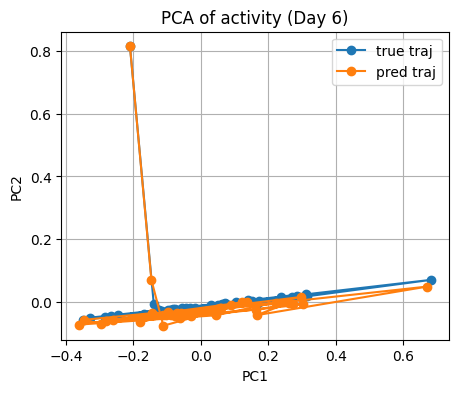

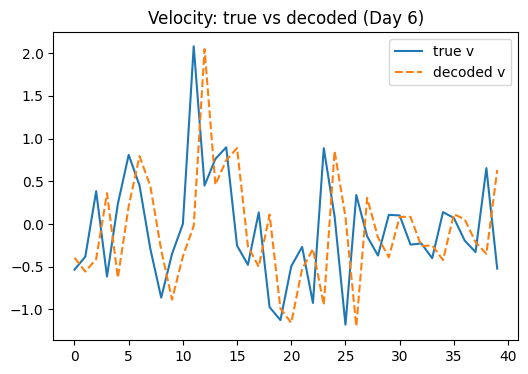

R² Day 6: -0.65795883159501
‖W6 - W3‖_F: 2.7045328617095947


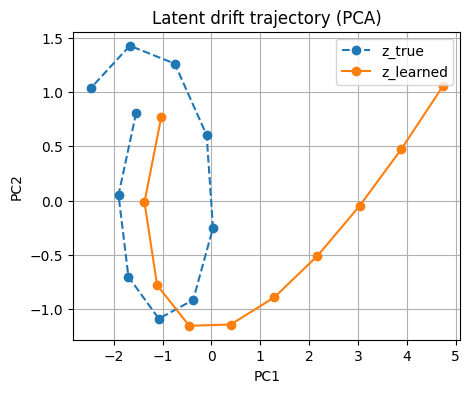

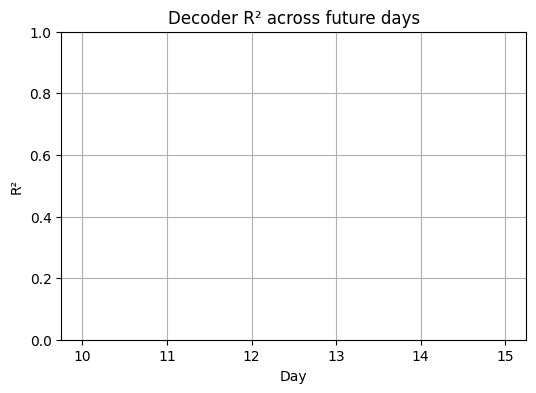

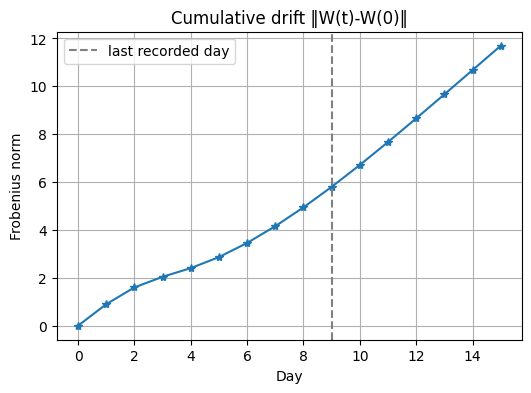

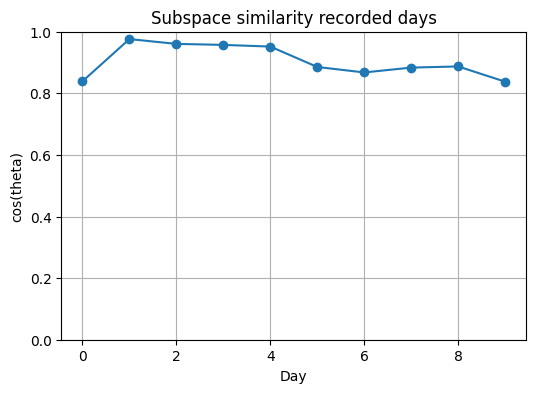

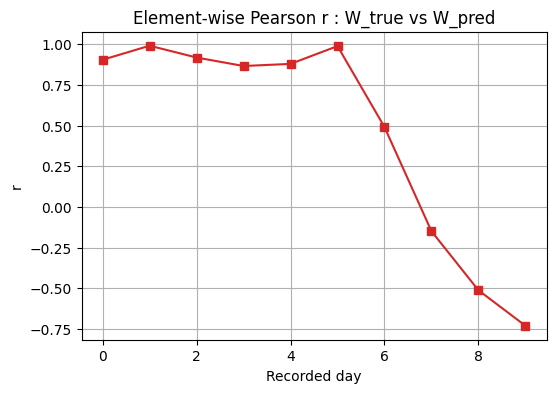

In [93]:
# Symmetry-Constrained PINN-RNN for Structured Drift Recovery
# ===========================================================
# This notebook trains on the FIRST 4 recorded days and then extrapolates to predict
# activity on Day 10 (a day never seen in data generation or training).
# It visualizes (i) latent drift, (ii) simulated activity for Day 10, and
# (iii) decoder accuracy on the extrapolated day.

# -----------------------
# Setup
# -----------------------
import torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles

plt.rcParams['figure.figsize'] = (6,4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# -----------------------
# Synthetic Data (10 recorded days)
# -----------------------
T_rec, S, K, N, rank = 10, 5, 40, 50, 3

W0 = 0.0005*torch.randn(N,N)
U,_,Vt = torch.linalg.svd(W0)
U, V = U[:,:rank], Vt[:rank,:].T
B = 0.05*torch.randn(N,1);  b = 0.1*torch.randn(N);  R = 0.05*torch.randn(1,N)

t_vals = torch.linspace(0,2*np.pi,T_rec)
z_true = torch.stack([torch.sin(t_vals+np.pi*i/rank)+0.1*t_vals for i in range(rank)],1)

x = torch.zeros(T_rec,S,K,N); v = torch.zeros(T_rec,S,K)
for t in range(T_rec):
    Wt = W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T
    for s in range(S):
        v_ts = 0.5*torch.randn(K)
        x_ts = torch.zeros(K,N); x_ts[0] = 0.1*torch.randn(N)
        for k in range(K-1):
            x_ts[k+1] = torch.tanh(Wt@x_ts[k] + (B*v_ts[k]).squeeze() + b)
        v[t,s] = v_ts; x[t,s] = x_ts

a = x.mean((0,1,2))  # fixed bias/excitability

# -----------------------
# Dataset / Dataloader (train on first 4 days)
# -----------------------
class SplitDS(Dataset):
    def __init__(self,x,v,days): self.x,self.v,self.days,self.S=x,v,days,x.shape[1]
    def __len__(self): return len(self.days)*self.S
    def __getitem__(self,idx): t= self.days[idx//self.S]; s=idx%self.S; return self.x[t,s],self.v[t,s],t

train_days = list(range(4))
loader = DataLoader(SplitDS(x,v,train_days),batch_size=4,shuffle=True)

# -----------------------
# Model (slow‑ODE + fast RNN)
# -----------------------
class SlowODE(nn.Module):
    def __init__(self,r):
        super().__init__(); self.net=nn.Sequential(nn.Linear(r+1,64),nn.Tanh(),nn.Linear(64,r))
    def forward(self,t,z):
        t = t if isinstance(t,float) else t.item(); tvec=torch.full_like(z[:,:1],t)
        return self.net(torch.cat([z,tvec],1))

class PINN(nn.Module):
    def __init__(self):
        super().__init__(); self.U,self.V,self.W0 = U.to(device),V.to(device),W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(rank)); self.slow = SlowODE(rank)
        self.B = nn.Parameter(B.clone()); self.R = nn.Parameter(R.clone()); self.b_fixed=a.to(device)
    def weights(self,T):
        times=torch.arange(T,dtype=torch.float32); z=odeint(self.slow,self.z0.unsqueeze(0),times).squeeze(1)
        return self.W0 + self.U @ torch.diag_embed(z) @ self.V.T
    def rnn_cell(self,xk,vk,W): return torch.tanh(W@xk + (self.B*vk).squeeze()+self.b_fixed)
    def forward(self,x0,v_seq,t_idx,Ws):
        W=Ws[t_idx]; rec=dec=0; x_prev=x0[0]
        for k in range(K-1):
            x_pred=self.rnn_cell(x_prev,v_seq[k],W)
            rec+= (x_pred - x0[k+1]).pow(2).sum(); dec+= (self.R@x_pred - v_seq[k]).pow(2)
            x_prev=x_pred
        return rec+0.1*dec

model=PINN().to(device); opt=torch.optim.Adam(model.parameters(),1e-3)

# -----------------------
# Training Loop
# -----------------------
for ep in range(500):
    L=0
    for xb,vb,tb in loader:
        xb,vb=xb.to(device),vb.to(device)
        Ws=model.weights(T_rec)
        loss=torch.stack([model(xb[i],vb[i],tb[i],Ws) for i in range(xb.size(0))]).mean()
        opt.zero_grad(); loss.backward(); opt.step(); L+=loss.item()
    if ep%5==0: print(f"Epoch {ep}: loss {L/len(loader):.3f}")

# -----------------------
# Extrapolate to **Day 6** (unseen in training)
# -----------------------

test_day = 6  # index 6  (7th recorded session)
T_pred = test_day + 1          # we need weights up to and including day 6
z_pred = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_pred).float()).squeeze(1).detach()
W6_pred = model.W0 + model.U @ torch.diag_embed(z_pred[test_day].unsqueeze(0))[0] @ model.V.T

# --- ground‑truth W6 from synthetic generator ---
W6_true = W0 + U @ torch.diag_embed(z_true[test_day].unsqueeze(0))[0] @ V.T

# === Simulate 1 trial on Day 6 using *true velocity* ===
vel6 = v[test_day,0].to(device)          # use velocity from session 6, trial 0
x_seed = x[test_day,0,0].to(device)      # start state same as ground truth

# Ground truth trajectory already stored in x[test_day,0]
true_traj = x[test_day,0].to(device)

# Predicted trajectory using learned W6_pred
pred_traj = [x_seed]
for k in range(K-1):
    pred_traj.append(torch.tanh(W6_pred @ pred_traj[-1] + (model.B*vel6[k]).squeeze() + model.b_fixed))
pred_traj = torch.stack(pred_traj)

# --- Plot heat‑maps side‑by‑side ---
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)
axs[0].imshow(true_traj.detach().cpu().T,aspect='auto',cmap='viridis'); axs[0].set_title('True Day 6')
axs[1].imshow(pred_traj.detach().cpu().T,aspect='auto',cmap='viridis'); axs[1].set_title('Predicted Day 6')
for ax in axs: ax.set_xlabel('Time'); axs[0].set_ylabel('Neuron')
plt.tight_layout(); plt.show()

# --- Neuron‑wise Pearson correlation ---
true_np = true_traj.detach().cpu().numpy(); pred_np = pred_traj.detach().cpu().numpy()
cc = [np.corrcoef(true_np[:,n], pred_np[:,n])[0,1] for n in range(N)]
plt.figure(figsize=(5,3)); plt.hist(cc,bins=20,color='C2'); plt.title('Neuron‑wise corr (Day 6)');
plt.xlabel('Correlation'); plt.ylabel('# neurons'); plt.show();
print('Mean corr Day 6:', np.nanmean(cc).round(3))

# --- PCA state‑space comparison (Day 6) ---
from sklearn.decomposition import PCA
comb = np.vstack([true_np, pred_np])            # shape [2K, N]
proj = PCA(n_components=2).fit_transform(comb)   # 2D embedding
true_proj = proj[:K]; pred_proj = proj[K:]
plt.figure(figsize=(5,4))
plt.plot(true_proj[:,0], true_proj[:,1],'o-',label='true traj')
plt.plot(pred_proj[:,0], pred_proj[:,1],'o-',label='pred traj')
plt.title('PCA of activity (Day 6)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

# --- Decoder performance Day 6 ---
vel_dec = (model.R @ pred_traj.T).squeeze().detach().cpu().numpy()
plt.figure(); plt.plot(vel6.cpu(),label='true v'); plt.plot(vel_dec,'--',label='decoded v');
plt.title('Velocity: true vs decoded (Day 6)'); plt.legend(); plt.show();
print('R² Day 6:', r2_score(vel6.cpu(), vel_dec))

# Drift magnitude W3 → W6
Ws_pred_all = model.weights(test_day+1).detach();
print('‖W6 - W3‖_F:', torch.norm(Ws_pred_all[test_day]-Ws_pred_all[3]).item())

# =====================================================
# Extended evaluation: multi‑day extrapolation & metrics
# =====================================================
# We extrapolate an additional 6 unseen days (Days 10–15) and inspect
#    1) learned latent trajectory vs. ground‑truth (PCA overlay),
#    2) decoder accuracy (R²) across future days,
#    3) cumulative drift magnitude of weights,
#    4) subspace similarity between learned and ground‑truth W(t) for recorded days.

T_future_ext = 6
T_pred_ext   = T_rec + T_future_ext  # 16 total days (0–15)

# --- Latent trajectory prediction for all days (0–15) ---
z_pred_all = odeint(model.slow, model.z0.unsqueeze(0), torch.arange(T_pred_ext).float()).squeeze(1).detach()

# PCA overlay of true (days 0–9) vs. learned (0–15)
from sklearn.decomposition import PCA
all_z = torch.cat([z_true, z_pred_all[:T_rec]], dim=0).cpu().numpy()
labels = np.array(['true']*T_rec + ['learned']*T_rec)
Z_2d = PCA(n_components=2).fit_transform(all_z)
plt.figure(figsize=(5,4))
plt.plot(Z_2d[labels=='true',0], Z_2d[labels=='true',1], 'o--', label='z_true', color='C0')
plt.plot(Z_2d[labels=='learned',0], Z_2d[labels=='learned',1], 'o-',  label='z_learned', color='C1')
plt.title('Latent drift trajectory (PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.show()

# --- Decoder R² for days 10–15 ---
from sklearn.metrics import r2_score
r2_fut = []
for f in range(T_future_ext):
    t_future = T_rec + f
    z_diag = torch.diag_embed(z_pred_all[t_future].unsqueeze(0))[0]
    W_fut  = model.W0 + model.U @ z_diag @ model.V.T
    v_sim  = 0.5*torch.randn(K).to(device)
    x_sim  = [x[0,0,0].to(device)]
    for k in range(K-1):
        x_sim.append(torch.tanh(W_fut@x_sim[-1] + (model.B*v_sim[k]).squeeze() + model.b_fixed))
    x_sim  = torch.stack(x_sim)
    v_dec  = (model.R@x_sim.T).squeeze().detach().cpu().numpy()
    r2_fut.append(r2_score(v_sim.cpu().numpy(), v_dec))

plt.figure();
plt.plot(np.arange(T_rec, T_pred_ext), r2_fut, 'o-');
plt.title('Decoder R² across future days'); plt.xlabel('Day'); plt.ylabel('R²');
plt.ylim(0,1); plt.grid(True); plt.show()

# --- Weight drift magnitude relative to Day 0 ---
Ws_learn_ext = model.weights(T_pred_ext).detach()
mag = [torch.norm(Ws_learn_ext[t]-Ws_learn_ext[0]).item() for t in range(T_pred_ext)]
plt.figure(); plt.plot(mag,'-*');
plt.axvline(x=T_rec-1, color='grey', ls='--', label='last recorded day');
plt.title('Cumulative drift ‖W(t)-W(0)‖'); plt.xlabel('Day'); plt.ylabel('Frobenius norm'); plt.legend(); plt.grid(True); plt.show()

# --- Subspace similarity learned vs. ground‑truth for recorded days (0‑9) ---
from scipy.linalg import subspace_angles

def subspace_sim(W1,W2,k=5):
    _,_,V1 = torch.linalg.svd(W1); _,_,V2 = torch.linalg.svd(W2)
    return np.cos(subspace_angles(V1[:,:k].cpu(), V2[:,:k].cpu())).mean()

Ws_true = [W0 + U @ torch.diag_embed(z_true[t].unsqueeze(0))[0] @ V.T for t in range(T_rec)]
Ws_learn_train = Ws_learn_ext[:T_rec]
sims = [subspace_sim(Ws_learn_train[t], Ws_true[t]) for t in range(T_rec)]
plt.figure(); plt.plot(sims,'o-'); plt.title('Subspace similarity recorded days');
plt.xlabel('Day'); plt.ylabel('cos(theta)'); plt.ylim(0,1); plt.grid(True); plt.show()

# ----------------------------------------------------------------
# NEW: Weight‑matrix correlation (element‑wise) per recorded day
# ----------------------------------------------------------------
flat_corr = []
for t in range(T_rec):
    w_true_flat  = Ws_true[t ].flatten().cpu().numpy()
    w_pred_flat  = Ws_learn_train[t].flatten().cpu().numpy()
    flat_corr.append( np.corrcoef(w_true_flat, w_pred_flat)[0,1] )

plt.figure(); plt.plot(flat_corr,'s-',color='C3');
plt.title('Element‑wise Pearson r : W_true vs W_pred');
plt.xlabel('Recorded day'); plt.ylabel('r'); plt.grid(True); plt.show()


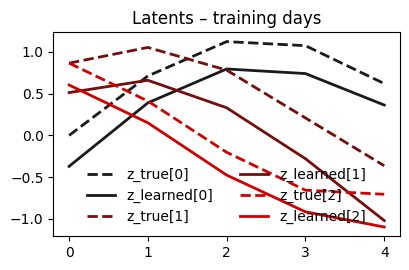

In [101]:
import numpy as np
import matplotlib.pyplot as plt

z_learn=odeint(model.slow,model.z0.unsqueeze(0),torch.arange(5).float()).squeeze(1).detach()
# --- create a custom dark‑red → gray gradient -------------------------------
rank = z_true.shape[1]                       # number of latents you’re plotting
end_rgb = np.array([209/255, 0.0, 0.0])    # dark red  (#8B0000)
# end_rgb   = np.array([0.50, 0.50, 0.50])     # medium gray
start_rgb   = np.array([0.1, 0.1, 0.1])     # medium gray
colors = [tuple(start_rgb*(1-t) + end_rgb*t) for t in np.linspace(0, 1, rank)]

# --- plot --------------------------------------------------------------------
plt.figure(figsize=(6*0.7,4*0.7))
for i, c in enumerate(colors):
    plt.plot(z_true[:5, i], linestyle='--',  color=c, linewidth=2,label=f'z_true[{i}]')
    plt.plot(z_learn[:, i], linestyle='-',   color=c, linewidth=2,label=f'z_learned[{i}]')

plt.title('Latents – training days')
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()


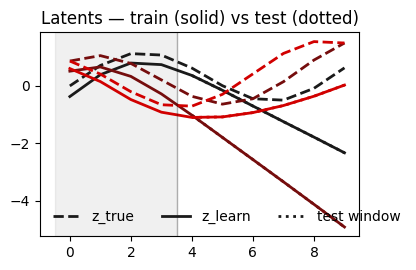

In [95]:
import numpy as np
import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt

T_train = 4
T_total = z_true.shape[0]
t_full  = torch.arange(T_total, dtype=torch.float32)

with torch.no_grad():
    z_learn_full = odeint(model.slow, model.z0.unsqueeze(0), t_full).squeeze(1).detach()

# colors
rank = z_true.shape[1]
end_rgb   = np.array([209/255, 0.0, 0.0])
start_rgb = np.array([0.1, 0.1, 0.1])
colors = [tuple(start_rgb*(1-t) + end_rgb*t) for t in np.linspace(0, 1, rank)]

plt.figure(figsize=(6*0.7, 4*0.7))

for i, c in enumerate(colors):
    # ground truth (dashed, full)
    plt.plot(np.arange(T_total), z_true[:, i], '--', color=c, linewidth=2,
             label='z_true' if i==0 else None)

    # learned (solid, full) — single continuous line
    plt.plot(np.arange(T_total), z_learn_full[:, i], '-', color=c, linewidth=2,
             label='z_learn' if i==0 else None)

    # overlay test segment with dotted style to highlight it
    plt.plot(np.arange(T_train, T_total), z_learn_full[T_train:, i], ':', color=c, linewidth=2,
             label='test window' if i==0 else None)

# shade train region + boundary
plt.axvspan(-0.5, T_train-0.5, alpha=0.06, color='k')
plt.axvline(T_train-0.5, color='k', linewidth=1, alpha=0.25)

plt.title('Latents — train (solid) vs test (dotted)')
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()


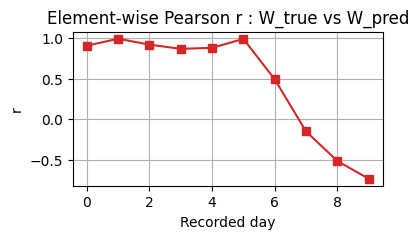

In [96]:
# ----------------------------------------------------------------
# NEW: Weight‑matrix correlation (element‑wise) per recorded day
# ----------------------------------------------------------------
flat_corr = []
for t in range(T_rec):
    w_true_flat  = Ws_true[t ].flatten().cpu().numpy()
    w_pred_flat  = Ws_learn_train[t].flatten().cpu().numpy()
    flat_corr.append( np.corrcoef(w_true_flat, w_pred_flat)[0,1] )

plt.figure(figsize=(4,2)); plt.plot(flat_corr,'s-',color='C3');
plt.title('Element‑wise Pearson r : W_true vs W_pred');
plt.xlabel('Recorded day'); plt.ylabel('r'); plt.grid(True); plt.show()


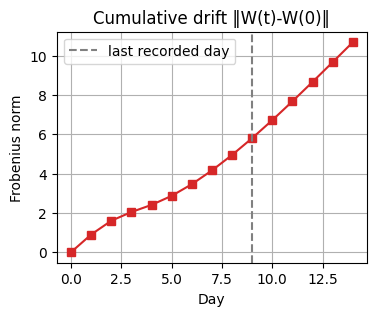

In [97]:
# --- Weight drift magnitude relative to Day 0 ---
Ws_learn_ext = model.weights(T_pred_ext).detach()
mag = [torch.norm(Ws_learn_ext[t]-Ws_learn_ext[0]).item() for t in range(T_pred_ext-1)]
plt.figure(figsize=(4,3)); plt.plot(mag,'s-',color='C3');
plt.axvline(x=T_rec-1, color='grey', ls='--', label='last recorded day');
plt.title('Cumulative drift ‖W(t)-W(0)‖'); plt.xlabel('Day'); plt.ylabel('Frobenius norm'); plt.legend(); plt.grid(True); plt.show()


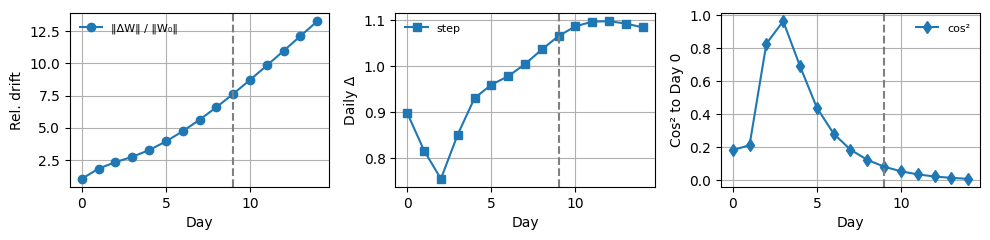

In [98]:
rel  = []
step = []
cos2 = []
rv   = []
for t in range(1, T_pred_ext):
    W0, Wt, Wtm1 = Ws_learn_ext[0], Ws_learn_ext[t], Ws_learn_ext[t-1]

    # Relative drift %
    rel.append((Wt - W0).norm() / W0.norm())

    # Step‑wise drift
    step.append((Wt - Wtm1).norm())

    # Squared cosine
    cos_sq = (torch.sum(W0.flatten()*Wt.flatten()) /
              (W0.norm()*Wt.norm()))**2
    cos2.append(cos_sq.item())

    # RV‑coefficient
    W0f, Wtf = W0.flatten(), Wt.flatten()
    rv.append(((W0f @ Wtf)**2 / ((W0f@W0f)*(Wtf@Wtf))).item())



fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True)
axs[0].plot(rel,  'o-', label='‖ΔW‖ / ‖W₀‖'); axs[0].set_ylabel('Rel. drift')
axs[1].plot(step, 's-', label='step');          axs[1].set_ylabel('Daily Δ')
axs[2].plot(cos2, 'd-', label='cos²');          axs[2].set_ylabel('Cos² to Day 0')
for ax in axs: 
    ax.axvline(T_rec-1, color='grey', ls='--')
    ax.grid(True); ax.legend(fontsize=8, frameon=False)
axs[0].set_xlabel('Day'); axs[1].set_xlabel('Day'); axs[2].set_xlabel('Day')
plt.tight_layout(); plt.show()


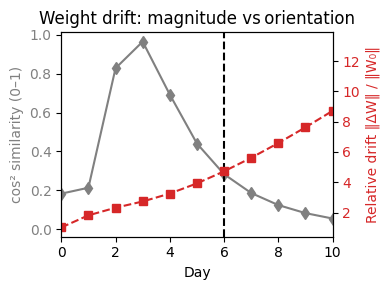

In [99]:
# ---------------------------------------------------------------
# cos²  (0‒1)  and   relative drift  (0‒∞)  on one plot
# ---------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(4, 3))

# --- cos² similarity (left y‑axis) ------------------------------
ax1.plot(cos2, 'd-', color='gray', label='cos² to Day 0')
ax1.set_ylabel('cos² similarity (0–1)', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_xlabel('Day')
# ax1.grid(True, axis='y')

# --- relative Frobenius drift (right y‑axis) --------------------
ax2 = ax1.twinx()
ax2.plot(rel, 's--', color='C3', label='‖ΔW‖ / ‖W₀‖')
ax2.set_ylabel('Relative drift ‖ΔW‖ / ‖W₀‖', color='C3')
ax2.tick_params(axis='y', labelcolor='C3')
ax2.set_xlim(0,10)
# --- vertical marker for last recorded day ----------------------
ax1.axvline(6, color='black', ls='--', label='last recorded day')

# --- combined legend -------------------------------------------
# lines, labels  = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines + lines2, labels + labels2,
#            frameon=False, loc='lower right', fontsize=10)

plt.title('Weight drift: magnitude vs orientation')
plt.tight_layout()
plt.show()
